In [21]:
!pip install -q keras
!pip install gym
!pip install “gym[atari]"

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [22]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import random
import numpy as np
from keras import backend as K
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

class Agent:

    def __init__(self):
        self.memory = []
        self.model = self.__model()

    def __model(self, lr=0.001):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=3, input_shape=(80, 80, 1), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Flatten())
        model.add(Dense(256, use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))             #relu -> DEAD NEURONS??? => leaky relu

        model.add(Dense(3))
        model.add(Activation('softmax'))
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=lr), metrics=['accuracy'])

        #model.summary()
        
        return model

    def preprocess(self, I):
        # prepro 210x160x3 uint8 frame into 6400 (80x80x1) 2D float vector
        I = I[35:195]  # crop
        I = I[::2, ::2, 0]  # downsample by factor of 2
        I[I == 144] = 0  # erase background (background type 1)
        I[I == 109] = 0  # erase background (background type 2)
        I[I != 0] = 1  # everything else (paddles, ball) just set to 1
        I= np.reshape(I, (80, 80, 1))
        return I

    def discount_rewards(self, r, gamma=0.99):
        """ take 1D float array of rewards and compute discounted reward """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, len(r))):
            if r[t] != 0: running_add = 0 # reset the sum
            running_add = running_add * gamma + r[t]
            discounted_r[t] = running_add
        #normalize
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return discounted_r

    def remember(self, state, action, actions, reward):
        # assure state has correct shape before keep in memory
        if (state.shape[0] != 80 or state.shape[1] != 80):
          return
        
        # store in memory the different states, actions, rewards...
        self.memory.append((state, action, actions, reward))

    def replay(self):
        # fit model from memory
        gamma = 0.99 # importance of the next reward

        # initialize
        list_x_batch, list_y_batch = [], []
        
        # get the list of rewards
        _, _, _, list_r_batch = zip(*self.memory)
        r_batch = self.discount_rewards(list_r_batch, gamma) #process rewards
        
        for i, (state, action, actions, _) in enumerate(self.memory):

            state = np.expand_dims(state, axis=0)
            r = r_batch[i]  #reward of ith step
            #print("in) a:{} as:{} r:{}".format(action, actions, r))
            #rw = np.full([3], -r/2)
            #rw[action] = r
            actions[action] += actions[action]*r
            #actions += actions*r
            #print("out) a:{} as:{} r:{}".format(action, actions, r))

            # append
            list_x_batch.append(state)
            list_y_batch.append(actions)

        # train the model
        x_batch = np.vstack(list_x_batch)
        y_batch = np.vstack(list_y_batch)

        # fitting
        self.model.fit(x_batch, y_batch, verbose=1, epochs=1)
        
        # clean
        self.memory.clear()

    def act(self, state):
        # preprocess the sample
        #state = self.preprocess(state)
        state = np.expand_dims(state, axis=0)

        # predict the action to do
        action_values = self.model.predict(state)
        #print("Prediction({}) from {}".format(np.argmax(action_values), action_values))

        return np.argmax(action_values), action_values[0]

In [109]:
## sanity check
import unittest
import gym
import numpy as np

class TestAgent(unittest.TestCase):
  
    @classmethod
    def setUpClass(cls):
      cls.agent = Agent()
    
    def test_init(self):
      self.assertEqual(len(self.agent.memory), 0)
      self.assertTrue(self.agent.model.count_params() < 2e6)

    def test_preprocess(self):
      env = gym.make("Pong-v0")
      observation = env.reset()
      processed = self.agent.preprocess(observation)
      #data
      self.assertEqual(np.min(processed), 0)
      self.assertEqual(np.max(processed), 1)
      #shape
      self.assertEqual(processed.shape[0], 80)
      self.assertEqual(processed.shape[1], 80)
      self.assertEqual(processed.shape[2], 1)

    def test_diff_observations(self):
      env = gym.make("Pong-v0")
      obs = env.reset()
      new_obs, _, _, _ = env.step(2)
      obs = self.agent.preprocess(obs)
      new_obs = self.agent.preprocess(new_obs)
      diff = new_obs - obs    
      #data
      self.assertEqual(np.unique(diff).tolist(), [0, 1, 255])
      
        
unittest.main(argv=[''], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.812s

OK


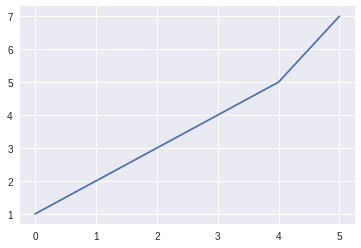

In [29]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def draw(x):
  plt.plot(x)
  display.clear_output(wait=True)
  plt.show()
  
m = [1,2,3,4,5,7]
draw(m)

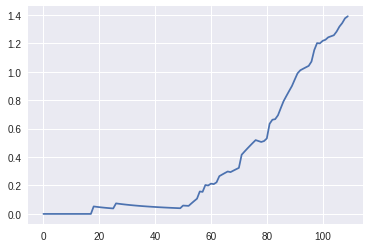

******* episode:111 wins:10 perf:1.468 ********
******* episode:112 wins:4 perf:1.491 ********
******* episode:113 wins:4 perf:1.513 ********
******* episode:114 wins:7 perf:1.561 ********
******* episode:115 wins:7 perf:1.609 ********
******* episode:116 wins:7 perf:1.655 ********
******* episode:117 wins:2 perf:1.658 ********
******* episode:118 wins:3 perf:1.669 ********
******* episode:119 wins:7 perf:1.714 ********
******* episode:120 wins:3 perf:1.725 ********


In [0]:
import os
import gym
import pickle
import random
import threading
import numpy as np
#from Agent import Agent
from time import sleep

!rm weights.h5
!rm data.pkl

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3
NO_ACTION = 0

# mapping actions: model output -> environment
action2move = {0:NO_ACTION, 1:UP_ACTION, 2:DOWN_ACTION}

# initializing our environment
env = gym.make("Pong-v0")

# beginning of an episode
observation = env.reset()
previousObs = np.zeros([80,80,1])

# model weights
h5file = "weights.h5"

# agent
agent = Agent()

# try to load previous model
if os.path.exists(h5file):
    agent.model.load_weights(h5file)

# training conf
training = True

# main loop
episode = 1
wins = 0
win_running_mean = 0
wins_list = []

while episode < 10000: 
    
    # predict action
    observation = agent.preprocess(observation)
    diffObs = observation - previousObs
    
    action, actions = agent.act(diffObs)
    move = action2move[action]     

    # do one step
    next_observation, reward, done, _ = env.step(move)

    # save the current observation
    agent.remember(diffObs, action, actions, reward)

    # update state
    previousObs = observation
    observation = next_observation

    ###
    # update variables, means and so on
    if reward == 1:
        wins += 1
                    
    if done:
        win_running_mean += (wins - win_running_mean)/(len(wins_list)+1)
        wins_list.append(win_running_mean)
        print("******* episode:{} wins:{} perf:{:.3f} ********".format(episode, wins, win_running_mean))
        
        if training and (episode % 10 == 0):
          #th1 = threading.Thread(target=agent.replay())
          #th1.start()
          agent.replay()

        # storing and printouts
        if episode % 100 == 0:
          agent.model.save_weights(h5file)
          with open('data.pkl', 'wb') as f:
            pickle.dump(wins_list, f)
            
        if episode % 10 == 0:
          draw(wins_list)
        
        # reset episode
        observation = env.reset()
        previousObs = np.zeros([80,80,1])
        wins = 0
        episode += 1

